In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.datasets import imdb
from nltk.stem.porter import PorterStemmer
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


In [2]:
imdb_data = pd.read_csv("IMDB Dataset.csv")
imdb_data.head(15)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [4]:
#Checking for Null values
imdb_data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [5]:
imdb_data["sentiment"].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

Equally distributed in terms of positive and negative comments

In [6]:
#Checking for Duplicates
imdb_data.duplicated().sum()

418

In [7]:
#Now Dropping duplicate comments
data1 = imdb_data.drop_duplicates(inplace = True)
data1 = imdb_data.reset_index()
data1 = data1.drop(["index"], axis = 1)

In [8]:
data1.shape

(49582, 2)

In [9]:
stop = stopwords.words('english')
w1 = WordNetLemmatizer()
stemmer = PorterStemmer()

In [10]:
X = data1["review"]
Y = data1["sentiment"]

In [11]:
for i in range(X.shape[0]):
    X[i] = re.sub('[^A-Za-z]', ' ', str(X[i]))       #remove non alphabetic characters, regex method

    X[i] = X[i].split(" ")                      #seperate sentences to words
    X[i] = [w for w in X[i] if w != ""]
    
    X[i] = [stemmer.stem(w) for w in X[i]]      #extracting root of the word. Gets rid of prefixes and suffixes.
    
    X[i] = [w.lower() for w in X[i]]            #make every word lower case
    X[i] = [w for w in X[i] if w not in stop]

In [12]:
#Creating a bag of words for each review
word_dict = {}
for i in range(X.shape[0]):
    for w in X[i]:
        if w not in word_dict:
            word_dict[w] = 0
        word_dict[w] += 1
word_dict = sorted(word_dict.items(), key= lambda x : x[1], reverse=True)

count = 0
for k,v in word_dict:
    count += 1
    if count == 21:
        break
    print(k,v)

br 200428
thi 149838
movi 102504
film 95233
wa 94834
hi 57405
one 55040
like 44836
ha 33156
time 31703
good 29989
make 29832
charact 28129
see 28006
get 27754
watch 27618
veri 27536
even 25153
stori 25121
would 24401


In [13]:
#10k most used words
most_freq_words = {}
count = 0
index = 0
for word, freq in word_dict:
    most_freq_words[word] = index
    index += 1
    count += 1
    if count == 10000:
        break
list(most_freq_words.items())[0:10]

[('br', 0),
 ('thi', 1),
 ('movi', 2),
 ('film', 3),
 ('wa', 4),
 ('hi', 5),
 ('one', 6),
 ('like', 7),
 ('ha', 8),
 ('time', 9)]

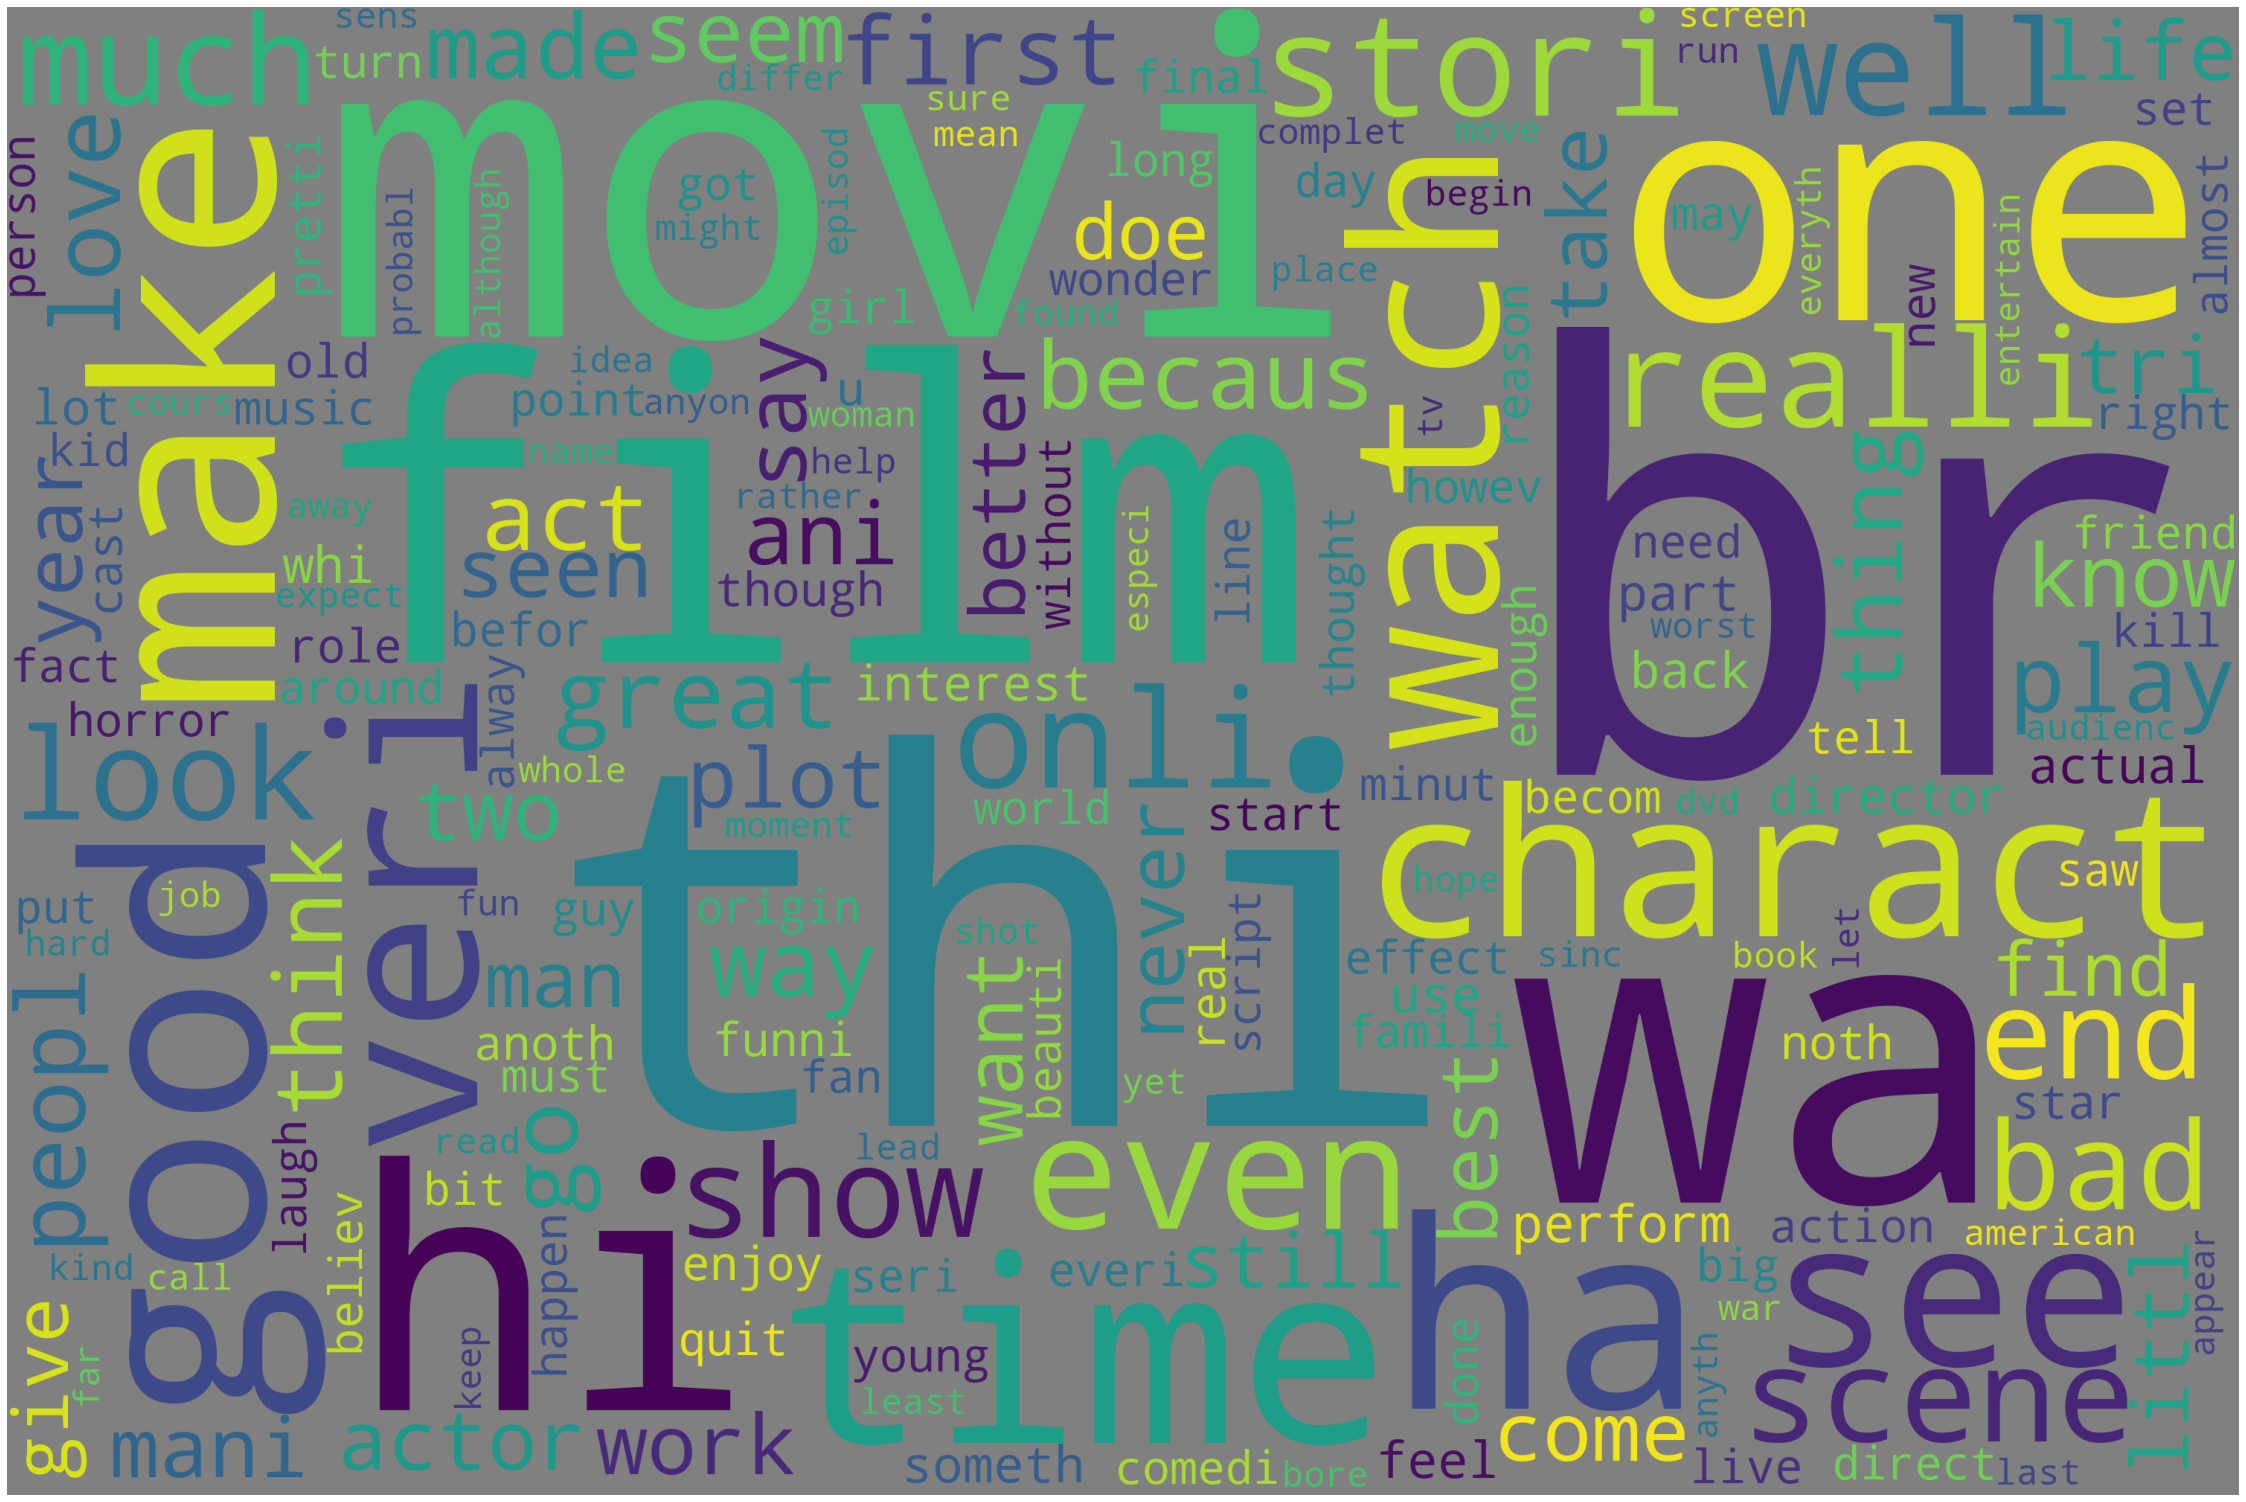

In [14]:
text = ""
count = 0
for k,v in word_dict:
    count += 1
    if count == 5000:
        break
    for i in range(v):
        text += k + " "

import matplotlib.pyplot as plt

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='grey', 
                      collocations=False, stopwords = STOPWORDS).generate(text)
plot_cloud(wordcloud)

In [15]:
# Removing words that are not in most frequent words dict

X_train = []
for i in range(X.shape[0]):
    list_ = []
    for w in X[i]:
        try:
            list_.append(most_freq_words[w])
        except:
            pass
    X_train.append(list_)

In [16]:
# Train, tune and test
leng = 0
for i in range(len(X_train)):
    leng += len(X_train[i])
leng / len(X_train)

125.54541970876528

In [17]:
X_train = np.array(X_train)
X_train = pad_sequences(X_train, 120)
print(X_train.shape)

(49582, 120)


In [18]:
#Converting Y to numeric
Y = [1 if i=="positive" else 0 for i in Y]

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, np.array(Y), test_size = 0.2)

In [20]:
#LSTM
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(10000, 32, input_length=120))
lstm_model.add(keras.layers.LSTM(100, return_sequences = True))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.LSTM(100, return_sequences = False))
lstm_model.add(keras.layers.Dropout(0.5))
lstm_model.add(keras.layers.Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer="rmsprop", loss=keras.losses.binary_crossentropy, metrics="accuracy")

In [21]:

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [22]:
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 0.00001
)
early_stopping = keras.callbacks.EarlyStopping(patience=5, verbose=1)
mcp_save = keras.callbacks.ModelCheckpoint('checkpoint_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose = 1)

In [23]:

history = lstm_model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data = (X_test, Y_test),
                   callbacks = [learning_rate_reduction, early_stopping, mcp_save])

Epoch 1/15
1240/1240 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.8400
Epoch 00001: val_loss improved from inf to 0.32548, saving model to checkpoint_model.hdf5
1240/1240 [==============================] - 187s 151ms/step - loss: 0.3641 - accuracy: 0.8400 - val_loss: 0.3255 - val_accuracy: 0.8803
Epoch 2/15
1240/1240 [==============================] - ETA: 0s - loss: 0.2730 - accuracy: 0.8917
Epoch 00002: val_loss improved from 0.32548 to 0.27863, saving model to checkpoint_model.hdf5
1240/1240 [==============================] - 186s 150ms/step - loss: 0.2730 - accuracy: 0.8917 - val_loss: 0.2786 - val_accuracy: 0.8841
Epoch 3/15
1240/1240 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9036
Epoch 00003: val_loss did not improve from 0.27863
1240/1240 [==============================] - 188s 152ms/step - loss: 0.2494 - accuracy: 0.9036 - val_loss: 0.3149 - val_accuracy: 0.8766
Epoch 4/15
1240/1240 [==============================] - ETA:

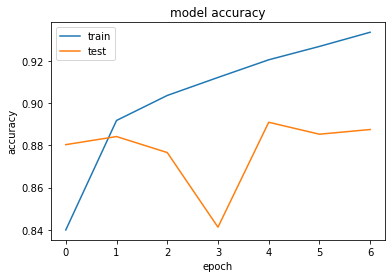

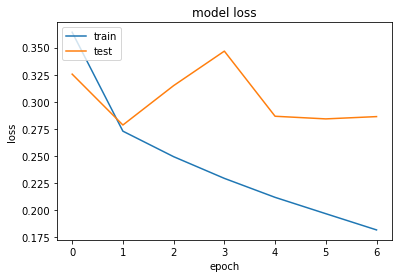

In [24]:
plot_history(history)

In [25]:
lstm_model.load_weights('checkpoint_model.hdf5')

In [26]:
#Prediction 
def predict(review):
    
    # remove non alphabetic characters
    review = re.sub('[^A-Za-z]', ' ', review) 
    
    # Stemmer
    review = review.split(" ")
    review = [w for w in review if w != ""]
    review = [stemmer.stem(w) for w in review]
    
    # remove stopwords
    review = [w for w in review if w not in stop]
    
    # get bag of words
    list_ = []
    for w in review:
        try:
            list_.append(most_freq_words[w])
        except:
            pass
    test = [list_]
    test = np.array(test)
    test = pad_sequences(test, 120)
#     pred = lstm_model.predict(test)[0][0]
    pred = lstm_model.predict(test)[0][0]
    print("Positive : ", pred)
    print("Negative : ", 1-pred)

In [30]:
# Review check for the movie Avengers
positive_review = "I have got to tell anyone who will listen that this is one of THE best adventure movies I have ever seen \ If you are a fan of epic adventure movies, then this is your dream come true \ Brilliant film from start to finish"

In [31]:
# 10-Star Reviews
predict(positive_review)

Positive :  0.9763816
Negative :  0.02361840009689331


In [34]:
# Review check for the movie Logan
negative_review = "Totally predictable and boring \ No suspense. Acting is OK. But the story was ridiculous \ Very dark, very grim"

In [35]:
# 2-star reviews
predict(negative_review)

Positive :  0.3333745
Negative :  0.6666254997253418
